
[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Using device: cpu


c:\Users\frank\lymphoid_malignancy_project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\frank\lymphoid_malignancy_project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



📋 Classification Report:
              precision    recall  f1-score   support

         CLL       1.00      1.00      1.00        16
          FL       1.00      1.00      1.00        19
         MCL       1.00      1.00      1.00        14

    accuracy                           1.00        49
   macro avg       1.00      1.00      1.00        49
weighted avg       1.00      1.00      1.00        49

✅ Accuracy: 1.0000


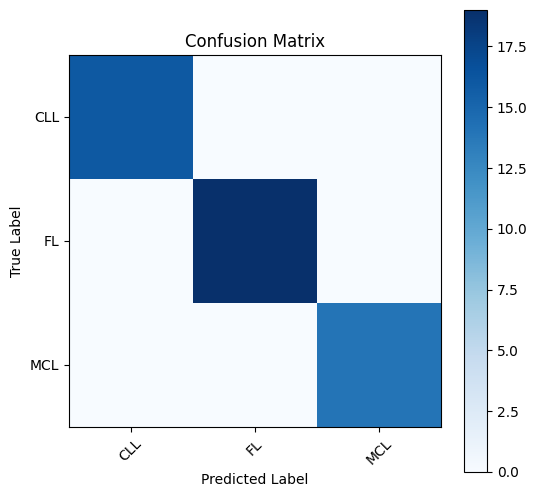

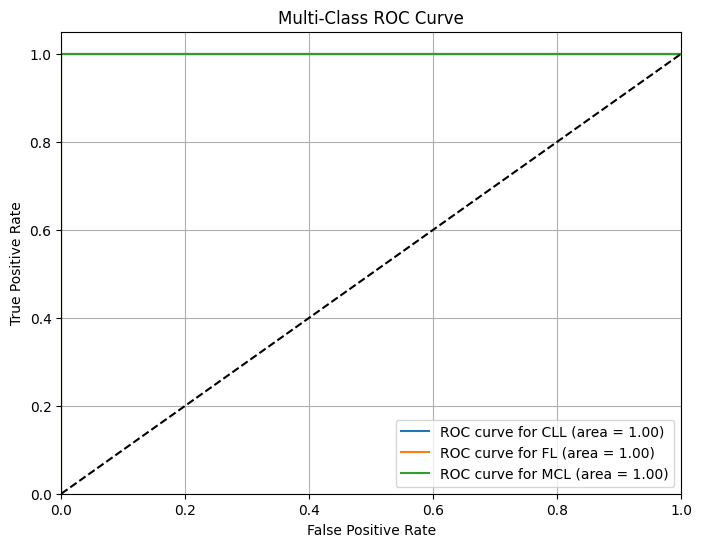

In [1]:
# notebooks/evaluate_model.ipynb

# --- Install required libraries if needed ---
%pip install scikit-learn

# --- Imports ---
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import sys
sys.path.append("../scripts")

from data_loader import load_tile_dataset

# --- Load Data ---
processed_tiles_folder = "../data/processed_tiles/"
batch_size = 32
image_size = 224

_, val_loader, class_names = load_tile_dataset(
    data_dir=processed_tiles_folder,
    batch_size=batch_size,
    shuffle=False,
    image_size=image_size,
    val_split=0.2
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Load Trained Model ---
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

model.load_state_dict(torch.load("../data/models/trained_resnet18.pth", map_location=device))
model.eval()

# --- Evaluate Model on Validation Set ---
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        probs = nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# --- Classification Report ---
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_names.keys())))

# --- Accuracy Score ---
accuracy = np.mean(y_true == y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")

# --- Confusion Matrix ---
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,6))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names.keys(), rotation=45)
plt.yticks(tick_marks, class_names.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.show()

# --- ROC Curve and AUC ---
fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8,6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve for {list(class_names.keys())[i]} (area = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
